In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.bool8 = np.bool_ 
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [3]:
import random, math
import numpy as np
from collections import defaultdict

class QLearningAgent():
  def __init__(self, alpha, epsilon, discount, getLegalActions):
    self.getLegalActions = getLegalActions
    self._qValues = defaultdict(lambda: defaultdict(lambda: 0))
    self.alpha = alpha
    self.epsilon = epsilon
    self.discount = discount

  def getQValue(self, state, action):
    if not (state in self._qValues) or not (action in self._qValues[state]):
        return 0.0
    return self._qValues[state][action]

  def setQValue(self, state, action, value):
    self._qValues[state][action] = value

  def getValue(self, state):
    possibleActions = self.getLegalActions(state)
    
    if not possibleActions:
        return 0.0
    return max(self.getQValue(state, action) for action in possibleActions)

  def getPolicy(self, state):
    possibleActions = self.getLegalActions(state)

    if not possibleActions:
        return None
    
    best_value = float('-inf')
    best_actions = []
    
    for action in possibleActions:
        q_value = self.getQValue(state, action)
        if q_value > best_value:
            best_value = q_value
            best_actions = [action]
        elif q_value == best_value:
            best_actions.append(action)
    
    return random.choice(best_actions)

  def getAction(self, state):
    possibleActions = self.getLegalActions(state)

    if not possibleActions:
        return None

    if random.random() < self.epsilon:
        return random.choice(possibleActions)
    else:
        return self.getPolicy(state)

  def update(self, state, action, nextState, reward):
    gamma = self.discount
    learning_rate = self.alpha

    current_q = self.getQValue(state, action)
    next_max_q = self.getValue(nextState)
    new_q = current_q + learning_rate * (reward + gamma * next_max_q - current_q)
    
    self.setQValue(state, action, new_q)

In [4]:
import gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [5]:
def play_and_train(env, agent, t_max=10000):
    total_reward = 0
    reset_result = env.reset()
    s = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    
    for _ in range(t_max):
        a = agent.getAction(s)
        step_result = env.step(a)
        
        if len(step_result) == 4:
            next_s, r, done, _ = step_result
        else:
            next_s, r, terminated, truncated, _ = step_result
            done = bool(terminated) or bool(truncated)
        
        if isinstance(next_s, tuple):
            next_s = next_s[0]
        
        agent.update(s, a, next_s, r)
        s = next_s
        total_reward += r
        
        if done:
            break
    
    return total_reward

In [6]:
agent = QLearningAgent(alpha=0.5, epsilon=1.0, discount=0.99,
                       getLegalActions=lambda s: range(n_actions))

Достигните положительной награды, постройте график

In [7]:
from IPython.display import clear_output


Эпизод 4500, Epsilon: 0.1053
Средняя награда (последние 100): 0.64
Лучшая награда: 15.00


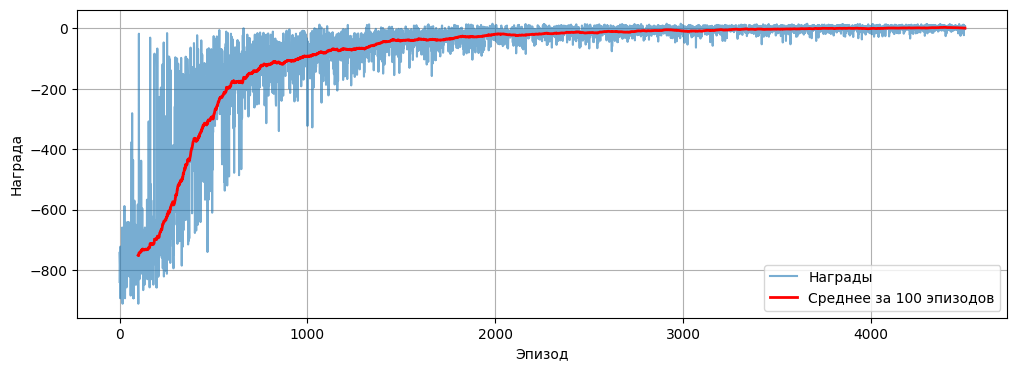

Сред: 6.13
Макс: 14.00
Мин: -14.00


In [8]:
from IPython.display import clear_output

rewards = []
best_reward = float('-inf')

for i in range(5000):
    episode_reward = play_and_train(env, agent)
    rewards.append(episode_reward)
    
    agent.epsilon = max(0.05, agent.epsilon * 0.9995)
    
    if episode_reward > best_reward:
        best_reward = episode_reward
    
    if i % 500 == 0:
        clear_output(True)
        avg_reward = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Эпизод {i}, Epsilon: {agent.epsilon:.4f}")
        print(f"Средняя награда (последние 100): {avg_reward:.2f}")
        print(f"Лучшая награда: {best_reward:.2f}")
        
        plt.figure(figsize=(12, 4))
        plt.plot(rewards, alpha=0.6, label='Награды')
        
        if len(rewards) >= 100:
            moving_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
            plt.plot(range(99, len(rewards)), moving_avg, 'r-', linewidth=2, label='Среднее за 100 эпизодов')
        
        plt.xlabel('Эпизод')
        plt.ylabel('Награда')
        plt.legend()
        plt.grid(True)
        plt.show()

test_agent = QLearningAgent(alpha=0.5, epsilon=0.05, discount=0.99,
                            getLegalActions=lambda s: range(n_actions))
test_agent._qValues = agent._qValues.copy()

test_rewards = []
for _ in range(100):
    test_rewards.append(play_and_train(env, test_agent))

print(f"Сред: {np.mean(test_rewards):.2f}")
print(f"Макс: {np.max(test_rewards):.2f}")
print(f"Мин: {np.min(test_rewards):.2f}")

## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [9]:
import gym
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

reset_result = env.reset()
if isinstance(reset_result, tuple):
    state = reset_result[0]
    print(f"first state: {state}")
else:
    print(f"first state: {reset_result}")


first state: [ 0.0116381  -0.03810744 -0.00460638 -0.02613913]


c:\Users\nikit\AppData\Local\Programs\Python\Python313\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [10]:
states = []
for _ in range(100):
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        s = reset_result[0]
    else:
        s = reset_result
    
    done = False
    while not done:
        states.append(s)
        a = env.action_space.sample()
        step_result = env.step(a)
        
        if len(step_result) == 4:
            s, r, done, _ = step_result
        else:
            s, r, terminated, truncated, _ = step_result
            done = terminated or truncated
        
        if isinstance(s, tuple):
            s = s[0]

states = np.array(states)
print(f"Собрано {len(states)} состояний")


Собрано 2344 состояний


### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

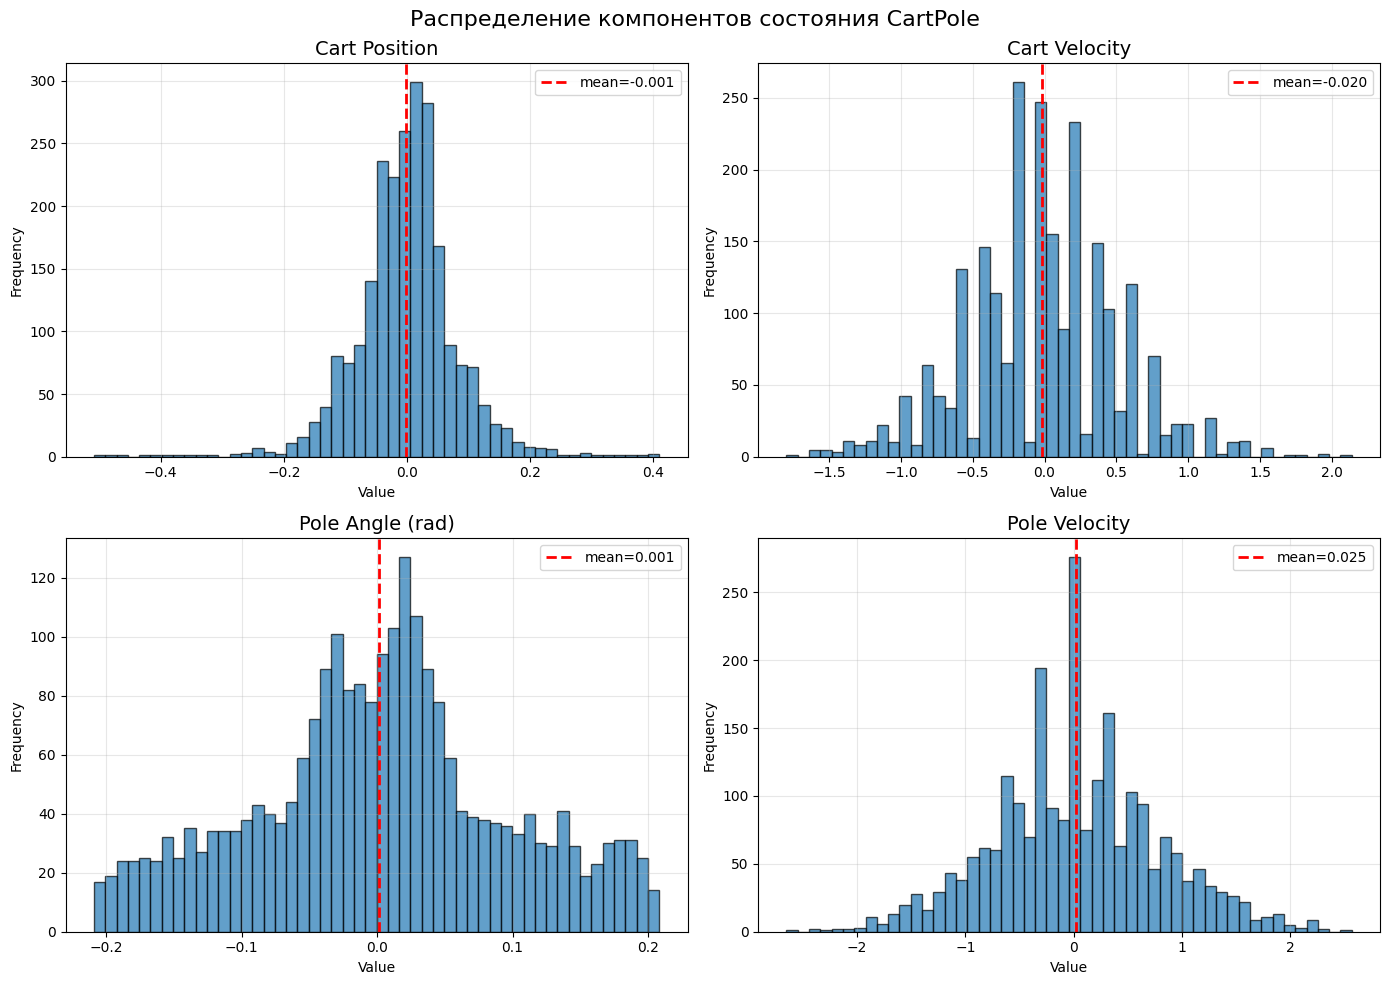

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
titles = ['Cart Position', 'Cart Velocity', 'Pole Angle (rad)', 'Pole Velocity']
for i, ax in enumerate(axes.flat):
    ax.hist(states[:, i], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    mean_val = np.mean(states[:, i])
    std_val = np.std(states[:, i])
    ax.axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'mean={mean_val:.3f}')
    ax.legend()

plt.suptitle('Распределение компонентов состояния CartPole', fontsize=16)
plt.tight_layout()
plt.show()

## Binarize environment

In [ ]:
from gym.core import ObservationWrapper
import numpy as np

class Binarizer(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.n_bins = (20, 20, 50, 20)

        left = np.linspace(-0.5, -0.1, 21)[:-1]
        middle = np.linspace(-0.1, 0.1, 31)
        right = np.linspace(0.1, 0.5, 21)[1:]
        angle_bins = np.concatenate([left, middle, right])
        
        self.bins = [
            np.linspace(-2.4, 2.4, self.n_bins[0] + 1)[1:-1],
            np.linspace(-4.0, 4.0, self.n_bins[1] + 1)[1:-1],
            angle_bins,
            np.linspace(-4.0, 4.0, self.n_bins[3] + 1)[1:-1]
        ]
    
    def to_bin(self, value, bins):
        return int(np.digitize(value, bins))
    
    def observation(self, obs):
        if isinstance(obs, tuple):
            obs = obs[0]
        return tuple(self.to_bin(obs[i], self.bins[i]) for i in range(4))

In [13]:
env = Binarizer(gym.make("CartPole-v0"))

## Learn

In [14]:
agent = QLearningAgent(alpha=0.1, epsilon=1.0, discount=0.99,
    getLegalActions=lambda s: range(n_actions) 
)

In [ ]:
rewards = []
rewBuf = []
ma = -1000000000000

for i in range(10000):
    for j in range(100):
        episode_reward = play_and_train(env, agent)
        rewards.append(episode_reward)
    
    agent.epsilon *= 0.99
    
    current_avg = np.mean(rewards[-100:])
    rewBuf.append(current_avg)
    
    clear_output(True)
    print(f"Эпизод: {i*100}")
    print(f"Epsilon: {agent.epsilon:.4f}")
    print(f"Средняя награда (последние 100): {current_avg:.2f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(rewBuf, 'b-', linewidth=2)
    plt.xlabel('Блоки по 100 эпизодов')
    plt.ylabel('Средняя награда')
    plt.title('Прогресс обучения CartPole')
    plt.axhline(y=195, color='r', linestyle='--', label='Цель (195)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

## 4. Experience replay (5 pts)

In [16]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)
        
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size):
        if batch_size > len(self._storage):
            batch_size = len(self._storage)
        
        indices = random.sample(range(len(self._storage)), batch_size)
        
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for idx in indices:
            data = self._storage[idx]
            states.append(data[0])
            actions.append(data[1])
            rewards.append(data[2])
            next_states.append(data[3])
            dones.append(data[4])
        
        return states, actions, rewards, next_states, dones

Some tests to make sure your buffer works right

In [17]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
states, actions, rewards, next_states, dones = replay.sample(1)
assert states[0] == obj1[0], "If there's just one object in buffer, it must be retrievable"
replay.add(*obj2)
assert len(replay._storage) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
states, actions, rewards, next_states, dones = replay.sample(100)
assert len(set(states)) == 1
replay.add(*obj1)
states, actions, rewards, next_states, dones = replay.sample(100)
assert len(set(states)) == 2
replay.add(*obj1)
states, actions, rewards, next_states, dones = replay.sample(100)
assert len(set(states)) == 1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [32]:
import gym
env = Binarizer(gym.make('CartPole-v0'))
n_actions = env.action_space.n

In [41]:
agent = QLearningAgent(alpha=0.5, epsilon=1.0, discount=0.99,
                       getLegalActions=lambda s: range(n_actions))

In [42]:
def play_and_train_with_replay(env, agent, replay, t_max=10000, batch_size=64, updates_per_step=4):
    total_reward = 0.0

    reset_result = env.reset()
    s = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        step_result = env.step(a)
        if len(step_result) == 4:
            next_s, r, done, _ = step_result
        else:
            next_s, r, terminated, truncated, _ = step_result
            done = bool(terminated) or bool(truncated)
        
        if isinstance(next_s, tuple):
            next_s = next_s[0]
        
        replay.add(s, a, r, next_s, done)
        s = next_s
        total_reward += r
        
        # Делаем несколько обновлений из буфера на каждом шаге
        if len(replay) >= batch_size:
            for _ in range(updates_per_step):
                states, actions, rewards, next_states, dones = replay.sample(batch_size)
                for i in range(batch_size):
                    if dones[i]:
                        target = rewards[i]  # терминальное состояние: просто награда
                    else:
                        target = rewards[i] + agent.discount * agent.getValue(next_states[i])
                    current_q = agent.getQValue(states[i], actions[i])
                    new_q = current_q + agent.alpha * (target - current_q)
                    agent.setQValue(states[i], actions[i], new_q)
        
        if done:
            break
    
    return total_reward

Train with experience replay

Блок: 10000/10000
Эпизодов всего: 1000000
Epsilon: 0.0500
Средняя (последние 100): 22.48
Макс в блоке: 79.00
Размер буфера: 50000/50000


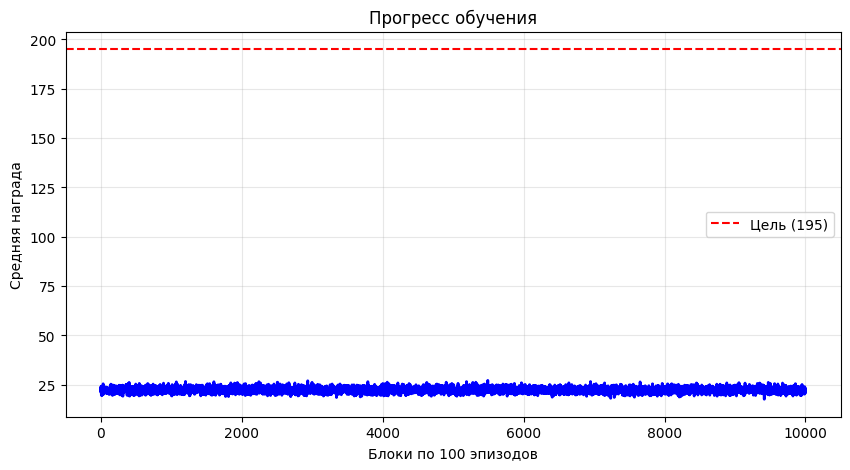

In [43]:
import gym
env = Binarizer(gym.make('CartPole-v0'))
n_actions = env.action_space.n

agent = QLearningAgent(alpha=0.5, epsilon=1.0, discount=0.99,
                       getLegalActions=lambda s: range(n_actions))

# Создаём большой буфер (не 2, а 50000)
replay = ReplayBuffer(50000)

# Предзаполняем буфер случайными переходами
print("Заполняем буфер случайными переходами...")
for _ in range(10000):
    reset_result = env.reset()
    s = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    done = False
    while not done:
        a = env.action_space.sample()
        step_result = env.step(a)
        if len(step_result) == 4:
            next_s, r, done, _ = step_result
        else:
            next_s, r, terminated, truncated, _ = step_result
            done = bool(terminated) or bool(truncated)
        if isinstance(next_s, tuple):
            next_s = next_s[0]
        replay.add(s, a, r, next_s, done)
        s = next_s
print("Буфер заполнен!")

rewards = []
rewBuf = []

for episode_block in range(10000):
    block_rewards = []
    
    for episode in range(100):
        episode_reward = play_and_train_with_replay(env=env, agent=agent, replay=replay,
                                                     batch_size=64, updates_per_step=4)
        rewards.append(episode_reward)
        block_rewards.append(episode_reward)
    
    # Медленное уменьшение epsilon, не опускаемся ниже 0.05
    agent.epsilon = max(0.05, agent.epsilon * 0.999)
    
    current_avg = np.mean(rewards[-100:])
    rewBuf.append(current_avg)
    
    clear_output(True)
    print(f"Блок: {episode_block+1}/10000")
    print(f"Эпизодов всего: {(episode_block+1)*100}")
    print(f"Epsilon: {agent.epsilon:.4f}")
    print(f"Средняя (последние 100): {current_avg:.2f}")
    print(f"Макс в блоке: {max(block_rewards):.2f}")
    print(f"Размер буфера: {len(replay)}/{replay._maxsize}")

    plt.figure(figsize=(10,5))
    plt.plot(rewBuf, 'b-', linewidth=2)
    plt.axhline(y=195, color='r', linestyle='--', label='Цель (195)')
    plt.xlabel('Блоки по 100 эпизодов')
    plt.ylabel('Средняя награда')
    plt.title('Прогресс обучения')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    if current_avg > 195:
        print(f"Достигнута средняя награда {current_avg:.2f} > 195")
        break